# 5章 顧客の退会を予測する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章では顧客の全体像を把握し、4章では数ヶ月利用している顧客の来月の利用回数の予測を行いました。   
ここでは、教師あり学習の分類を用いて、顧客の退会予測を取り扱います。

### ノック41：データを読み込んで利用データを整形しよう

In [1]:
import pandas as pd

In [2]:
customer = pd.read_csv("customer_join.csv")
uselog_months = pd.read_csv("use_log_months.csv")

In [3]:
year_months = list(uselog_months["年月"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]].copy()
    tmp.rename(columns={"count": "count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-1]].copy()
    del tmp_before["年月"]
    tmp_before.rename(columns={"count": "count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)
uselog.head()

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


### ノック42：退会前月の退会顧客データを作成しよう

In [4]:
from dateutil.relativedelta import relativedelta

In [5]:
exit_customer = customer.loc[customer["is_deleted"]==1].copy()
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in exit_customer.index:
    exit_customer.loc[i, "exit_date"] = exit_customer.loc[i, "end_date"] - relativedelta(months=1)
exit_customer["exit_date"] = pd.to_datetime(exit_customer["exit_date"])
exit_customer["年月"] = exit_customer["exit_date"].dt.strftime("%Y%m")
uselog["年月"] = uselog["年月"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "年月"], how="left")
print(len(uselog))
exit_uselog.head()

33851


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [6]:
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,通常,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30


### ノック43：継続顧客のデータを作成しよう

In [7]:
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on="customer_id", how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"])
print(len(conti_uselog))

33851
27422


In [8]:
conti_uselog = conti_uselog.sample(frac=1, random_state=0).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog.head()

2842


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaN,CA2,...,オールタイム,10500.0,入会費半額,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaN,CA1,...,オールタイム,10500.0,通常,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaN,CA1,...,オールタイム,10500.0,通常,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaN,CA1,...,ナイト,6000.0,通常,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaN,CA1,...,オールタイム,10500.0,通常,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0


In [9]:
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaN,CA2,...,10500.0,入会費半額,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaT
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaN,CA1,...,10500.0,通常,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0,NaT
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaN,CA1,...,10500.0,通常,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0,NaT
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaN,CA1,...,6000.0,通常,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0,NaT
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaN,CA1,...,10500.0,通常,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0,NaT


### ノック44：予測する月の在籍期間を作成しよう

In [10]:
predict_data["period"] = 0
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i, "now_date"], predict_data.loc[i, "start_date"])
    predict_data.loc[i, "period"] = int(delta.years*12 + delta.months)
predict_data.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201806,AS015233,7,7.0,XXXXX,C01,M,2018-05-13,NaN,CA2,...,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0,NaT,0,2018-06-01
1,201812,AS046594,7,5.0,XXX,C01,M,2018-03-01,NaN,CA1,...,7.166667,7.0,10.0,5.0,1.0,2019-04-30,13.0,NaT,9,2018-12-01
2,201808,OA769163,6,4.0,XXX,C01,M,2017-05-01,NaN,CA1,...,6.083333,6.0,8.0,2.0,1.0,2019-04-30,23.0,NaT,15,2018-08-01
3,201805,AS981537,10,6.0,XX,C03,M,2018-02-01,NaN,CA1,...,6.916667,7.0,10.0,5.0,1.0,2019-04-30,14.0,NaT,3,2018-05-01
4,201805,GD065188,6,7.0,XX,C01,M,2017-09-01,NaN,CA1,...,6.333333,6.5,9.0,3.0,1.0,2019-04-30,19.0,NaT,8,2018-05-01


### ノック45：欠損値を除去しよう

In [11]:
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1               255
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [12]:
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2639
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2639
period                  0
now_date                0
dtype: int64

### ノック46：文字列型の変数を処理できるように整形しよう

In [13]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,入会費半額,オールタイム,M,7.0,1.0,0,0.0
1,通常,オールタイム,M,5.0,1.0,9,0.0
2,通常,オールタイム,M,4.0,1.0,15,0.0
3,通常,ナイト,M,6.0,1.0,3,0.0
4,通常,オールタイム,M,7.0,1.0,8,0.0


In [14]:
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
0,7.0,1.0,0,0.0,1,0,0,1,0,0,0,1
1,5.0,1.0,9,0.0,0,0,1,1,0,0,0,1
2,4.0,1.0,15,0.0,0,0,1,1,0,0,0,1
3,6.0,1.0,3,0.0,0,0,1,0,0,1,0,1
4,7.0,1.0,8,0.0,0,0,1,1,0,0,0,1


In [15]:
del predict_data["campaign_name_通常"]
del predict_data["class_name_ナイト"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,7.0,1.0,0,0.0,1,0,1,0,0
1,5.0,1.0,9,0.0,0,0,1,0,0
2,4.0,1.0,15,0.0,0,0,1,0,0
3,6.0,1.0,3,0.0,0,0,0,0,0
4,7.0,1.0,8,0.0,0,0,1,0,0


### ノック47：決定木を用いて退会予測モデルを作成してみよう

In [16]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

In [17]:
exit = predict_data.loc[predict_data["is_deleted"]==1]
conti = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit), random_state=0)

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.

In [19]:
results_test = pd.DataFrame({"y_test": y_test, "y_pred": y_test_pred})
results_test.head()

,y_test,y_pred
1091,0.0,1.0
1786,0.0,0.0
1439,0.0,0.0
745,1.0,1.0
820,1.0,0.0


### ノック48：予測モデルの評価を行ない、モデルのチューニングをしてみよう

In [20]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.8916349809885932


In [21]:
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8916349809885932
0.9759188846641318


In [23]:
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9201520912547528
0.9252217997465145


### ノック49：モデルに寄与している変数を確認しよう

In [24]:
importance = pd.DataFrame({"feature_names": X.columns, "coefficient": model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.363986
1,routine_flg,0.136646
2,period,0.487865
3,campaign_name_入会費半額,0.000000
4,campaign_name_入会費無料,0.006751
5,class_name_オールタイム,0.004607
6,class_name_デイタイム,0.000146
7,gender_F,0.000000


### ノック50：顧客の退会を予測しよう

In [25]:
!pip install japanize_matplotlib
from sklearn import tree
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

     |████████████████████████████████| 4.1 MB 292 kB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=40e20f80c611af3b86e97283bb8675547bd3f1d471fba649efe6e4ab404d47ad
  Stored in directory: /Users/shonakamura/Library/Caches/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib


[Text(0.5643939393939394, 0.9166666666666666, 'period <= 11.5\ngini = 0.5\nsamples = 1578\nvalue = [792, 786]'),
 Text(0.26515151515151514, 0.75, 'count_1 <= 5.5\ngini = 0.392\nsamples = 955\nvalue = [256, 699]'),
 Text(0.12121212121212122, 0.5833333333333334, 'count_1 <= 4.5\ngini = 0.083\nsamples = 600\nvalue = [26, 574]'),
 Text(0.06060606060606061, 0.4166666666666667, 'period <= 0.5\ngini = 0.016\nsamples = 496\nvalue = [4, 492]'),
 Text(0.030303030303030304, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.09090909090909091, 0.25, 'count_1 <= 3.5\ngini = 0.012\nsamples = 495\nvalue = [3, 492]'),
 Text(0.06060606060606061, 0.08333333333333333, 'gini = 0.0\nsamples = 359\nvalue = [0, 359]'),
 Text(0.12121212121212122, 0.08333333333333333, 'gini = 0.043\nsamples = 136\nvalue = [3, 133]'),
 Text(0.18181818181818182, 0.4166666666666667, 'routine_flg <= 0.5\ngini = 0.334\nsamples = 104\nvalue = [22, 82]'),
 Text(0.15151515151515152, 0.25, 'gini = 0.0\nsamples = 35\nvalue = [0, 

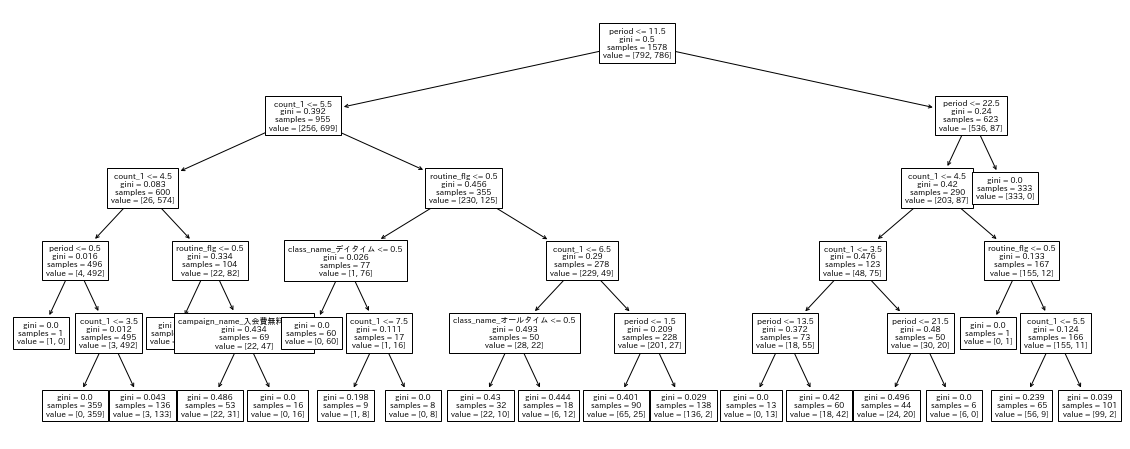

In [27]:
plt.figure(figsize=(20, 8))
tree.plot_tree(model, feature_names=X.columns, fontsize=8)

In [28]:
count_1 = 3
routine_flg = 1
period = 10
campaign_name = "入会費無料"
class_name = "オールタイム"
gender = "M"

In [29]:
if campaign_name == "入会費半額":
    campaign_name_list = [1, 0]
elif campaign_name == "入会費無料":
    campaign_name_list = [0, 1]
elif campaign_name == "通常":
    campaign_name_list = [0, 0]
if class_name == "オールタイム":
    class_name_list = [1, 0]
elif class_name == "デイタイム":
    class_name_list = [0, 1]
elif class_name == "ナイト":
    class_name_list = [0, 0]
if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]

input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)
input_data = pd.DataFrame(data=[input_data], columns=X.columns)

In [30]:
print(model.predict(input_data))
print(model.predict_proba(input_data))

[1.]
[[0. 1.]]
